In [1]:
import numpy as np
import pandas as pd
import scipy
from matplotlib import pyplot as plt
import os
import sys
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import Recall

In [2]:
df = pd.read_csv("Covid Data.csv")

In [3]:
def get_scores(y_test, y_pred):
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    return acc, f1, prec, rec

In [4]:
#Wir fügen zuerst ein neues Attribut hinzu, das angibt, ob die Person gestorben ist oder nicht.
#Die Verschlüsselung erfolgt konsistent mit den anderen Attributen (2 für "nein", 1 für "ja").
#Das Todesdatum wird als Attribut verworfen.

df['DIED'] = [2 if i=='9999-99-99' else 1 for i in df.DATE_DIED]
df=df.drop(columns='DATE_DIED')

In [5]:
#Eine Analyse der Missing Values zeigt, dass diese vor allem in den Spalten "PREGNANT", "ICU" und "INTUBED" vorkommen.
#Das Attribut "PREGNANT" wird bei allen männlichen Patienten auf 2 gesetzt.
#Das Attribut "PATIENT_TYPE" gibt an, ob die Person hospitalisiert war oder nicht. Bei allen Patienten ohne
#Krankenhausaufenthalt kann das Attribut "ICU" auf 2 gesetzt werden, da keiner dieser Patienten folglich auf
#einer Intensivstation behandelt wurde.
#Dieselbe Vorgehensweise wenden wir auf das Attribut "INTUBED" an. Dazu gehen wir von der Grundannahme aus, dass
#ein Anschluss an ein Beatmungsgerät im Rahmen eines Klinikaufenthaltes erfolgt. Etwaige Fälle von Heimintubation
#vernachlässigen wir dabei.

df.loc[df.SEX==2,'PREGNANT']=2
df.loc[df.PATIENT_TYPE==1,'ICU']=2
df.loc[df.PATIENT_TYPE==1,'INTUBED']=2

In [6]:
#Für die anderen fehlenden Werte können keine sinnvollen Aussagen getroffen werden. Da sie nur einen sehr kleinen
#Anteil des gesamten Datensatzes ausmachen (2.76%), verwerfen wir sie.

for col in df.columns.drop('AGE'):
    for i in [97,98, 99]:
        df[col]=df[col].replace(i , np.nan)

df=df.dropna()

In [7]:
#Wir normieren das Attribut "AGE" auf das Intervall [0,1] und bilden die "2" bei den binären Attributen auf die "0" ab
df['AGE'] = (df['AGE'] - df['AGE'].min()) / (df['AGE'].max() - df['AGE'].min())

for col in df.columns.drop(['AGE','CLASIFFICATION_FINAL', 'MEDICAL_UNIT', 'PATIENT_TYPE', 'USMER']):
    re_map_dict = {2:0}
    df[col]=df[col].replace(re_map_dict)

<ipython-input-7-7a0d027bdb3e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['AGE'] = (df['AGE'] - df['AGE'].min()) / (df['AGE'].max() - df['AGE'].min())
<ipython-input-7-7a0d027bdb3e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col]=df[col].replace(re_map_dict)


In [8]:
#Als Zielvariable wählen wir "DIED" aus
target='DIED'

In [9]:
for col in ['CLASIFFICATION_FINAL', 'PATIENT_TYPE', 'ICU', 'INTUBED', 'DIED']:
    print(df[col].value_counts())

CLASIFFICATION_FINAL
7    488131
3    375920
6    117178
5     25175
1      8397
4      3082
2      1783
Name: count, dtype: int64
PATIENT_TYPE
1    830385
2    189281
Name: count, dtype: int64
ICU
0.0    1003258
1.0      16408
Name: count, dtype: int64
INTUBED
0.0    986730
1.0     32936
Name: count, dtype: int64
DIED
0    946356
1     73310
Name: count, dtype: int64


In [10]:
df.drop(columns=["INTUBED","ICU"], inplace=True)

In [11]:
#Wir verwerfen die beiden Attribute 'MEDICAL_UNIT' und 'USMER'

# discarded_features = ['MEDICAL_UNIT', 'USMER','PATIENT_TYPE','INTUBED','ICU','PNEUMONIA']
discarded_features = ["SEX", "PREGNANT", "COPD", "ASTHMA", "INMSUPR", "OTHER_DISEASE", "CARDIOVASCULAR",
                      "OBESITY","TOBACCO"]
df = df.drop(discarded_features, axis=1)

#Wir testen die Attribute auf Korrelation mit der Zielvariablen testen und verwerfen alle Attribute,
#die unter einem gewissen Schwellwert liegen. (->andere Feature Selection Methoden ausprobieren)

# threshold=0.04
# selected_features=df.corr()[target][abs(df.corr()[target])>threshold].index
# not_selected_features=df.corr()[target][abs(df.corr()[target])<threshold]
# print(not_selected_features)
# df=df[selected_features]

In [12]:
#df = pd.get_dummies(df,columns=["MEDICAL_UNIT","CLASIFFICATION_FINAL"],drop_first=True)
df = pd.get_dummies(df,columns=["CLASIFFICATION_FINAL"],drop_first=True)

In [13]:
print(f'Samples where person died: {len(df[df["DIED"]==1])}')
print(f'Samples where person did not die: {len(df[df["DIED"]==0])}')

print(f'% of samples where person died: {len(df[df["DIED"]==1]) / len(df[df["DIED"]==0]) * 100:.3f}')

Samples where person died: 73310
Samples where person did not die: 946356
% of samples where person died: 7.747


In [14]:
# Undersample negative samples and oversample positive samples

df_dead = df[df["DIED"]==1].copy()
df_alive = df[df["DIED"]==0].sample(n=len(df_dead))

#Wir teilen den Datensatz in Trainings- und Testdatensatz auf.

test_size_dead=0.1
train_dead, test_dead = train_test_split(df_dead, test_size=test_size_dead, shuffle=True)

test_size_alive=0.1
train_alive, test_alive = train_test_split(df_alive, test_size=test_size_alive, shuffle=True)

train = pd.concat([train_dead, train_alive], axis=0)
test = pd.concat([test_dead, test_alive], axis=0)

train_y = train[target]
train_x = train.drop(target,axis=1)

test_y = test[target]
test_x = test.drop(target,axis=1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best Validation Loss: 0.2269
Best Validation Accuracy: 0.9185
459/459 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy: 0.9161778747783386
F1: 0.9196679521537355
Precision: 0.8829066265060241
Recall: 0.9596235165734552



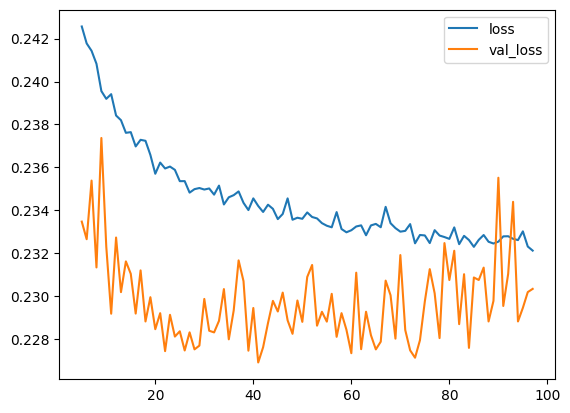

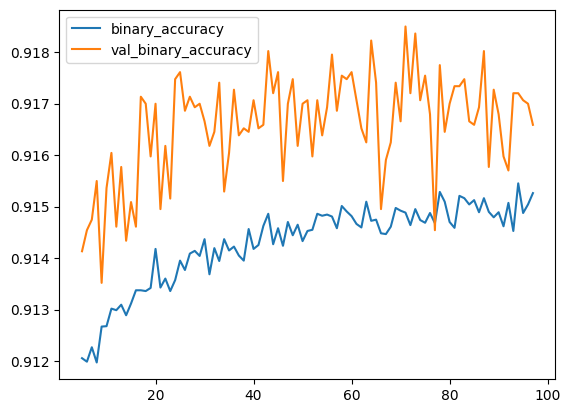

In [16]:
#Wir wenden einen Deep-Learning-Ansatz auf den Datensatz an.

model = keras.Sequential([
        layers.Dense(256, activation='relu', input_shape=[train_x.shape[1]]),
        layers.Dense(1024, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
model.optimizer.learning_rate.assign(10e-3)

early_stopping = keras.callbacks.EarlyStopping(patience=75, min_delta=0.001, restore_best_weights=True)

history = model.fit(train_x, train_y, validation_data=(test_x, test_y), batch_size=256, epochs=1000,
                    callbacks=[early_stopping], verbose=0)

history_df = pd.DataFrame(history.history)
history_df.loc[5:, ['loss', 'val_loss']].plot()
history_df.loc[5:, ['binary_accuracy', 'val_binary_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" + "\nBest Validation Accuracy: {:0.4f}").format(history_df['val_loss'].min(),
                  history_df['val_binary_accuracy'].max()))

y_pred = (model.predict(test_x) > 0.5).astype("int32")
acc, f1, prec, rec = get_scores(test_y, y_pred)
print(f'Accuracy: {acc}')
print(f'F1: {f1}')
print(f'Precision: {prec}')
print(f'Recall: {rec}'+"\n")


In [18]:
import os
import argparse
import time
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from collections import OrderedDict

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [20]:
class TabularDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float64)
        self.labels = torch.tensor(labels).type(torch.LongTensor)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx].to(device), self.labels[idx].to(device)


In [21]:
# Create Dataset objects
train_dataset = TabularDataset(train_x.astype(np.float64).values, train_y.astype(np.float64).values)
test_dataset = TabularDataset(test_x.astype(np.float64).values, test_y.astype(np.float64).values)

# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [22]:
class DNDT(nn.Module):
    def __init__(self, depth, num_features, used_features_rate, num_classes):
        super(DNDT, self).__init__()
        self.depth = depth
        self.num_leaves = 2**depth
        self.num_classes = num_classes

        num_used_features = int(num_features * used_features_rate)
        one_hot = np.eye(num_features)
        sampled_feature_indicies = np.random.choice(np.arange(num_features), num_used_features,
                                                   replace=False)
        self.used_features_mask = one_hot[sampled_feature_indicies]
        self.used_features_mask = torch.DoubleTensor(self.used_features_mask)

        # Initialize the weights of the classes in leaves
        self.pi = torch.randn((self.num_leaves, self.num_classes), requires_grad=True)

        self.decision_fn = nn.Sequential(OrderedDict([
            ('linear1', nn.Linear(num_used_features, self.num_leaves)),
            ('sigmoid', nn.Sigmoid())
        ]))

    def forward(self, x):
        if x.is_cuda and not self.used_features_mask.is_cuda:
            self.used_features_mask = self.used_features_mask.cuda()

        batch_size = x.shape[0]
        #x = x @ self.used_features_mask.T
        x = torch.mm(x, self.used_features_mask.T)

        decisions = torch.unsqueeze(self.decision_fn(x), dim=2)
        decisions = torch.cat((decisions, 1-decisions),dim=2)

        mu = torch.ones((batch_size, 1, 1)).cuda()

        begin_idx=1
        end_idx=2
        # Traverse tree in breadth-first order
        for level in range(self.depth):
            mu = mu.view(batch_size, -1, 1).repeat(1, 1, 2)
            level_decision = decisions[:, begin_idx:end_idx, :]
            mu = mu * level_decision
            begin_idx=end_idx
            end_idx = begin_idx + 2 ** (level+1)

        mu = mu.view(batch_size, self.num_leaves)
        probabilities = F.softmax(self.pi, dim=1).cuda().double()
        outputs = torch.mm(mu, probabilities)
        return outputs

In [23]:
def train(model=None, dataset_loader=None, optim=None, epochs=10):
    loss_arr = []
    for epoch in range(0, epochs):
        batch_losses = []
        for X, y in dataset_loader:

            out = model(X)
            loss = criterion(out, y)
            loss_np = loss.detach().cpu().item()
            batch_losses.append(loss_np)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        epoch_loss = np.sum(batch_losses)
        print(f'loss in epoche {epoch} : {epoch_loss}')
        loss_arr.append(epoch_loss)

In [ ]:
model = DNDT(8, train_x.shape[1], 1., 2)
model = model.double().to(device)
model

DNDT(
  (decision_fn): Sequential(
    (linear1): Linear(in_features=25, out_features=256, bias=True)
    (sigmoid): Sigmoid()
  )
)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
train(model=model, dataset_loader=train_loader, optim=optimizer, epochs=100)

loss in epoche 0 : 300.0898919293668
loss in epoche 1 : 250.13612188446263
loss in epoche 2 : 237.79884124202087
loss in epoche 3 : 231.3570429789278
loss in epoche 4 : 227.0361482470504
loss in epoche 5 : 224.49077779951716
loss in epoche 6 : 222.99223220910596
loss in epoche 7 : 221.98981878090396
loss in epoche 8 : 221.23310474699156
loss in epoche 9 : 220.683783909905
loss in epoche 10 : 220.2389807194636
loss in epoche 11 : 219.86738736550203
loss in epoche 12 : 219.55918298711532
loss in epoche 13 : 219.30829065894778
loss in epoche 14 : 219.07228836626246
loss in epoche 15 : 218.90234490799145
loss in epoche 16 : 218.7265740571741
loss in epoche 17 : 218.5741376586863
loss in epoche 18 : 218.44680439486967
loss in epoche 19 : 218.30646303559195
loss in epoche 20 : 218.20898630633855
loss in epoche 21 : 218.13257111792262
loss in epoche 22 : 218.017417945428
loss in epoche 23 : 217.9379191381836
loss in epoche 24 : 217.86389797004637
loss in epoche 25 : 217.7835885400807
loss in 

In [ ]:
model.eval()
L = np.empty((0, 2))
for X, y in test_loader:
    test_out = model(X).detach().cpu().numpy()
    L = np.append(L, test_out, axis=0)

y_pred = L.argmax(axis=1)
y_pred = L.argmax(axis=1)

acc, f1, prec, rec = get_scores(test_y, y_pred)
print(f'Accuracy: {acc}')
print(f'F1: {f1}')
print(f'Precision: {prec}')
print(f'Recall: {rec}'+"\n")

Accuracy: 0.910858000272814
F1: 0.914165626847048
Precision: 0.8814589665653495
Recall: 0.9493929886782158



In [24]:
class DNDF(nn.Module):
    def __init__(self, num_trees, depth, num_features, used_features_rate, num_classes):
        super(DNDF, self).__init__()
        self.ensemble = nn.ModuleList()
        self.num_classes = num_classes
        self.num_trees = num_trees

        for _ in range(num_trees):
            self.ensemble.append(
                DNDT(depth, num_features, used_features_rate, num_classes).cuda()
            )

    def forward(self, x):
        batch_size = x.shape[0]
        outputs = torch.zeros((batch_size, self.num_classes)).cuda()

        for tree in self.ensemble:
            outputs += tree(x)

        outputs /= len(self.ensemble)
        return outputs

In [25]:
model = DNDF(25, 8, train_x.shape[1], .9, 2)
model = model.double().cuda()

In [26]:
optimizer = optim.Adam(list(model.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss()
train(model=model, dataset_loader=train_loader, optim=optimizer, epochs=100)

loss in epoche 0 : 298.7102979719639
loss in epoche 1 : 253.92008674144745
loss in epoche 2 : 239.8700306415558
loss in epoche 3 : 233.06266021728516
loss in epoche 4 : 229.42013350129128
loss in epoche 5 : 227.12149733304977
loss in epoche 6 : 225.42787712812424
loss in epoche 7 : 224.0778973698616
loss in epoche 8 : 223.05342349410057
loss in epoche 9 : 222.22567531466484
loss in epoche 10 : 221.52901157736778
loss in epoche 11 : 220.86308032274246
loss in epoche 12 : 220.2054105103016
loss in epoche 13 : 219.7713360786438
loss in epoche 14 : 219.39904418587685
loss in epoche 15 : 219.05618971586227
loss in epoche 16 : 218.76946738362312
loss in epoche 17 : 218.52130335569382
loss in epoche 18 : 218.31533813476562
loss in epoche 19 : 218.1080427467823
loss in epoche 20 : 217.9417645931244
loss in epoche 21 : 217.76883378624916
loss in epoche 22 : 217.62001901865005
loss in epoche 23 : 217.48812755942345
loss in epoche 24 : 217.35636779665947
loss in epoche 25 : 217.23699381947517
los

In [27]:
model.eval()
L = np.empty((0, 2))
for X, y in test_loader:
    test_out = model(X).detach().cpu().numpy()
    L = np.append(L, test_out, axis=0)

y_pred = L.argmax(axis=1)
y_pred = L.argmax(axis=1)

acc, f1, prec, rec = get_scores(test_y, y_pred)
print(f'Accuracy: {acc}')
print(f'F1: {f1}')
print(f'Precision: {prec}')
print(f'Recall: {rec}'+"\n")

Accuracy: 0.9135861410448779
F1: 0.9165514061779622
Precision: 0.8861436576668364
Recall: 0.9491201746010094

